In [1]:
import yfinance as yf

# Download BTC-USD data
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-09-01", interval="1d")
btc.to_csv("bitcoin.csv")  # Save as CSV

# Download ETH-USD data
eth = yf.download("ETH-USD", start="2020-01-01", end="2025-09-01", interval="1d")
eth.to_csv("ethereum.csv")  # Save as CSV

print("BTC & ETH data saved successfully!")

# downloaded from yahoofinance

C:\Users\user\AppData\Local\Temp\ipykernel_20880\1658344304.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-01-01", end="2025-09-01", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_20880\1658344304.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2020-01-01", end="2025-09-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


BTC & ETH data saved successfully!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load dataset
df = pd.read_csv("bitcoin.csv")


In [4]:
# Show summary info about the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2072 non-null   object
 1   Close   2071 non-null   object
 2   High    2071 non-null   object
 3   Low     2071 non-null   object
 4   Open    2071 non-null   object
 5   Volume  2071 non-null   object
dtypes: object(6)
memory usage: 97.3+ KB


In [5]:
# Display summary statistics for numerical columns (count, mean, std, min, 25%, 50%, 75%, max)
df.describe()

,Date,Close,High,Low,Open,Volume
count,2072,2071,2071,2071,2071,2071
unique,2072,2071,2071,2070,2071,2071
top,8/31/2025,108236.7109,109491,27375.60156,108818.4609,47986191770
freq,1,1,1,2,1,1


In [6]:
df.shape

(2072, 6)

In [10]:
# Count the number of missing (null) values in each column
df.isnull().sum()

Date      0
Close     1
High      1
Low       1
Open      1
Volume    1
dtype: int64

In [13]:
# List of numeric columns to fill
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [14]:
# Forward fill first, then backward fill for any remaining missing values
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')

In [15]:
# Check missing values after filling
print("Missing values after filling:\n", df.isnull().sum())

Missing values after filling:
 Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2072 non-null   object
 1   Close   2072 non-null   object
 2   High    2072 non-null   object
 3   Low     2072 non-null   object
 4   Open    2072 non-null   object
 5   Volume  2072 non-null   object
dtypes: object(6)
memory usage: 97.3+ KB


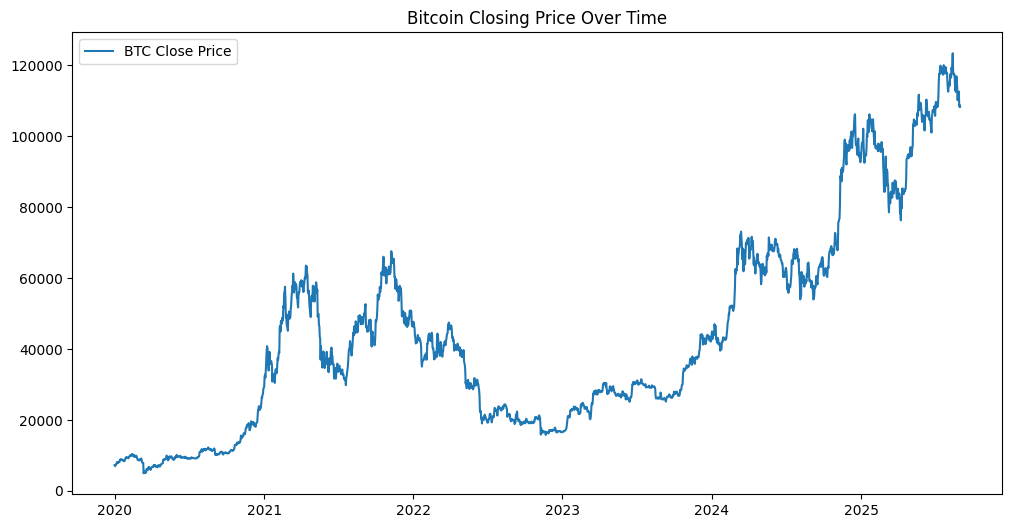

In [17]:
# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(btc.index, btc['Close'], label='BTC Close Price')
plt.title("Bitcoin Closing Price Over Time")
plt.legend()
plt.show()

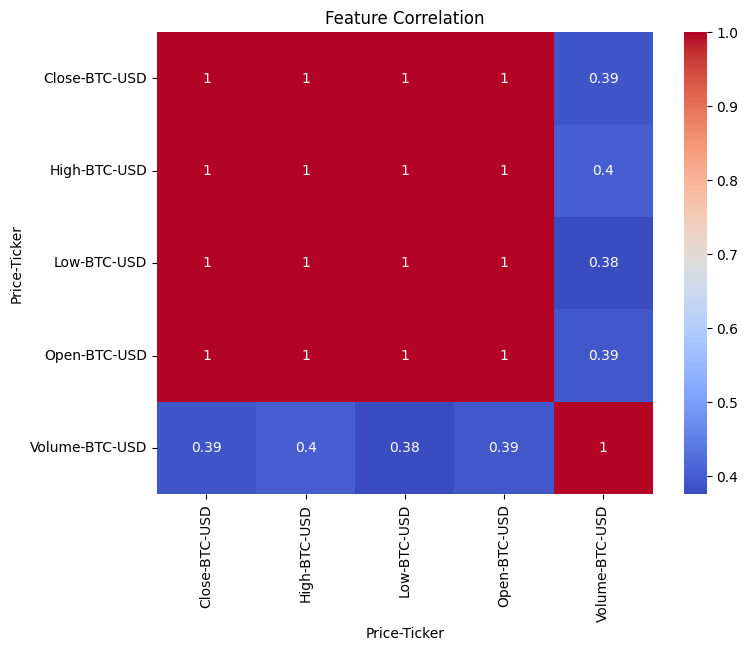

In [18]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(btc.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [19]:
# Convert date column to datetime if exists
if 'Date' in btc.columns:
    btc['Date'] = pd.to_datetime(btc['Date'])
    btc.set_index('Date', inplace=True)

In [21]:
# Convert Date/Time column to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)
elif 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df.set_index('Timestamp', inplace=True)
else:
    print("No Date or Timestamp column found. Time-series analysis may not work.")

In [22]:
# Convert price/volume columns to numeric
numeric_cols = ["Price", "Close", "High", "Low", "Open", "Volume"]
for col in numeric_cols:
    if col in df.columns:
        # Remove commas and spaces, convert to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "").str.strip(), errors="coerce")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, NaT to 2025-08-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2070 non-null   float64
 1   High    2070 non-null   float64
 2   Low     2070 non-null   float64
 3   Open    2070 non-null   float64
 4   Volume  2070 non-null   float64
dtypes: float64(5)
memory usage: 97.1 KB


In [24]:
# Save cleaned dataset
df.to_csv("bitcoin_cleaned.csv", index=False)

In [39]:
# Features and target
X = btc.drop(columns=['Close', 'Date'], errors='ignore')
y = btc['Close']

In [40]:
# Train-test split (time series: shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [43]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=5)
}


In [44]:
# Function to evaluate model
def evaluate_model(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred)
    }


In [45]:
# Train, predict, evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = evaluate_model(y_test, y_pred)
    scores["Model"] = name
    results.append(scores)

In [46]:
# Convert to DataFrame for better display
results_df = pd.DataFrame(results)[["Model", "R2", "RMSE", "MAE"]].sort_values(by="R2", ascending=False)
print(results_df)

               Model        R2          RMSE           MAE
1   Ridge Regression  0.997756    906.732326    655.562935
0  Linear Regression  0.997756    906.732327    655.562936
2      Random Forest -0.718980  25094.145227  19941.911653
3            XGBoost -0.732472  25192.431917  20112.032901


# Feature Engineering

In [48]:
# Lag of 1,2,3,7,14 days
for lag in [1,2,3,7,14]:
    btc[f'Close_lag_{lag}'] = btc['Close'].shift(lag)


In [ ]:
# Rolling mean and standard deviation of past prices.
for window in [3,7,14,30]:
    btc[f'Close_roll_mean_{window}'] = btc['Close'].rolling(window).mean()
    btc[f'Close_roll_std_{window}'] = btc['Close'].rolling(window).std()

In [51]:
# Difference between current price and previous prices.
btc['Momentum_1'] = btc['Close'] - btc['Close'].shift(1)  # daily momentum
btc['Momentum_7'] = btc['Close'] - btc['Close'].shift(7)  # weekly momentum


In [ ]:
# Difference between short-term and long-term moving averages.
btc['MA_diff'] = btc['Close_roll_mean_7'] - btc['Close_roll_mean_30']


In [52]:
# Rolling averages and momentum of trading volume.
btc['Volume_roll_mean_7'] = btc['Volume'].rolling(7).mean()
btc['Volume_momentum_1'] = btc['Volume'] - btc['Volume'].shift(1)


In [53]:
# Drop rows with NaN created by feature engineering
btc.dropna(inplace=True)

btc.to_csv("btc_2_feature_engineered.csv", index=False)

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)


In [56]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_scores[name] = {
        "R2": r2_score(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

print(model_scores)


{'LinearRegression': {'R2': 0.9977556824042101, 'RMSE': np.float64(906.7323267010617), 'MAE': np.float64(655.562935535075)}, 'RandomForest': {'R2': -0.7086450474659955, 'RMSE': np.float64(25018.592202053074), 'MAE': np.float64(19872.813675460446)}, 'XGBoost': {'R2': -0.7239527702331543, 'RMSE': np.float64(25130.412605821384), 'MAE': np.float64(20099.61031853865)}}


In [57]:
# Convert to DataFrame
scores_df = pd.DataFrame(model_scores)

# Save to CSV
scores_df.to_csv("btc_model_scores.csv", index=False)
print("Model scores saved to btc_model_scores.csv")

Model scores saved to btc_model_scores.csv


# Hyperparameter Tuning

In [64]:
# Ridge hyperparameter tuning
ridge = Ridge()
params_ridge = {"alpha": [0.1, 1.0, 10, 100]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5)
grid_ridge.fit(X_train, y_train)

print("Best Ridge params:", grid_ridge.best_params_)

# Best Ridge model
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_ridge)
rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Ridge -> R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Best Ridge params: {'alpha': 0.1}
Ridge -> R2: 0.9978, RMSE: 902.22, MAE: 660.09


In [65]:
rf = RandomForestRegressor(random_state=42)
params_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5]
}
grid_rf = GridSearchCV(rf, params_rf, cv=3)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest -> R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest -> R2: -0.7568, RMSE: 25368.48, MAE: 20194.07


In [66]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(random_state=42)
params_xgb = {
    "n_estimators":[100, 200],
    "learning_rate":[0.01, 0.1],
    "max_depth":[3, 5, 7]
}

rand_xgb = RandomizedSearchCV(xgb, params_xgb, cv=3, n_iter=5, random_state=42)
rand_xgb.fit(X_train, y_train)

print("Best XGB params:", rand_xgb.best_params_)

best_xgb = rand_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_xgb)
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost -> R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Best XGB params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
XGBoost -> R2: -0.7325, RMSE: 25192.43, MAE: 20112.03


In [67]:

results = [
    {"Model":"Ridge", "R2":r2_score(y_test, y_pred_ridge), "RMSE":mean_squared_error(y_test, y_pred_ridge, squared=False), "MAE":mean_absolute_error(y_test, y_pred_ridge)},
    {"Model":"Random Forest", "R2":r2_score(y_test, y_pred_rf), "RMSE":mean_squared_error(y_test, y_pred_rf, squared=False), "MAE":mean_absolute_error(y_test, y_pred_rf)},
    {"Model":"XGBoost", "R2":r2_score(y_test, y_pred_xgb), "RMSE":mean_squared_error(y_test, y_pred_xgb, squared=False), "MAE":mean_absolute_error(y_test, y_pred_xgb)}
]

pd.DataFrame(results).to_csv("btc_tuned_model_scores.csv", index=False)


In [71]:
import joblib

joblib.dump(best_ridge, "best_ridge_model.pkl")
joblib.dump(best_rf, "best_rf_model.pkl")
joblib.dump(best_xgb, "best_xgb_model.pkl")



['best_xgb_model.pkl']

In [75]:
# Save as streamlit_app.py
import streamlit as st

# Load data and model
btc = pd.read_csv("btc_processed.csv")
model = joblib.load("best_ridge_model.pkl")  # example

st.title("Bitcoin Price Prediction")


2025-09-02 02:25:14.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:25:15.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [88]:
import streamlit as st
import pandas as pd

# Example: load your BTC dataset

btc = pd.read_csv("bitcoin.csv")

# Ensure Date column exists and is datetime
if 'Date' in btc.columns:
    btc['Date'] = pd.to_datetime(btc['Date'], errors='coerce')
    btc.set_index('Date', inplace=True)
else:
    st.error("No Date column found!")

In [89]:
# Now btc.index is datetime, you can safely use .date()
start_date = st.date_input("Start date", btc.index.min().date())
end_date = st.date_input("End date", btc.index.max().date())

2025-09-02 02:43:07.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:07.717 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [90]:
# Filter BTC data by selected date range
mask = (btc.index >= pd.to_datetime(start_date)) & (btc.index <= pd.to_datetime(end_date))
filtered_btc = btc.loc[mask]

In [91]:
# Display filtered BTC data
st.subheader(f"BTC Data from {start_date} to {end_date}")
st.dataframe(filtered_btc)

2025-09-02 02:43:31.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:31.297 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:35.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:35.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [92]:
# Predicted BTC price for a specific date
selected_date = st.date_input(
    "Select a date to view predicted BTC price",
    value=btc.index.max().date(),
    min_value=btc.index.min().date(),
    max_value=btc.index.max().date()
)

2025-09-02 02:43:55.047 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:55.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:55.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:55.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:43:55.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [93]:
selected_date_ts = pd.to_datetime(selected_date)
if selected_date_ts in btc.index and 'Predicted_Close' in btc.columns:
    pred_price = btc.loc[selected_date_ts, 'Predicted_Close']
    st.write(f"Predicted BTC price on {selected_date}: ${pred_price:,.2f}")
else:
    st.write("Prediction for the selected date is not available.")

2025-09-02 02:44:10.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:44:10.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:44:10.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 02:44:10.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


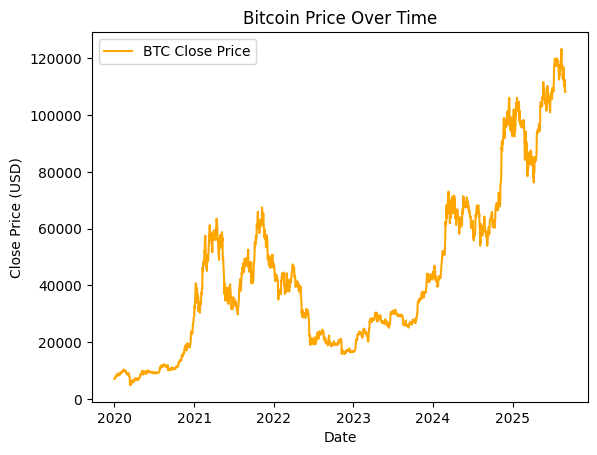

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
btc = pd.read_csv("bitcoin.csv")

# Ensure Date column is datetime
btc["Date"] = pd.to_datetime(btc["Date"], errors="coerce")

# Ensure Close column is numeric
btc["Close"] = pd.to_numeric(btc["Close"], errors="coerce")

# Drop rows where Date or Close is missing
btc = btc.dropna(subset=["Date", "Close"])

# Now plot safely
plt.plot(btc["Date"], btc["Close"], label="BTC Close Price", color="orange")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin Price Over Time")
plt.legend()
plt.show()


In [16]:
print(btc.dtypes)
print(btc.head())


Date      datetime64[ns]
Close            float64
High              object
Low               object
Open              object
Volume            object
dtype: object
        Date        Close              High               Low  \
2 2020-01-01  7200.174316  7254.33056640625   7174.9443359375   
3 2020-01-02  6985.470215   7212.1552734375  6935.27001953125   
4 2020-01-03  7344.884277  7413.71533203125       6914.996094   
5 2020-01-04  7410.656738   7427.3857421875  7309.51416015625   
6 2020-01-05  7411.317383   7544.4970703125  7400.53564453125   

               Open       Volume  
2  7194.89208984375  18565664997  
3  7202.55126953125  20802083465  
4   6984.4287109375  28111481032  
5  7345.37548828125  18444271275  
6  7410.45166015625  19725074095  


In [17]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# --- Title ---
st.title("📈 Bitcoin Price Analysis App")

# --- Upload CSV ---
uploaded_file = st.file_uploader("Upload your BTC-USD.csv file", type=["csv"])

if uploaded_file is not None:
    # Load dataset
    btc = pd.read_csv(uploaded_file)

    # --- Data Cleaning ---
    # Convert Date column to datetime
    btc["Date"] = pd.to_datetime(btc["Date"], errors="coerce")

    # Convert Close column to numeric
    btc["Close"] = pd.to_numeric(btc["Close"], errors="coerce")

    # Drop missing values
    btc = btc.dropna(subset=["Date", "Close"])

    # --- Show Dataset ---
    st.subheader("🔎 Data Preview")
    st.write(btc.head())

    # --- Plot Closing Price ---
    st.subheader("📊 Bitcoin Closing Price Over Time")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(btc["Date"], btc["Close"], label="BTC Close Price", color="orange")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.set_title("Bitcoin Price Over Time")
    ax.legend()
    st.pyplot(fig)

    # --- Histogram ---
    st.subheader("📊 Price Distribution")
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(btc["Close"], bins=50, kde=True, ax=ax, color="blue")
    ax.set_xlabel("Price (USD)")
    ax.set_title("Distribution of Closing Prices")
    st.pyplot(fig)

    # --- Moving Average ---
    st.subheader("📈 30-Day Moving Average")
    btc["MA30"] = btc["Close"].rolling(30).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(btc["Date"], btc["Close"], label="Close Price", alpha=0.6)
    ax.plot(btc["Date"], btc["MA30"], label="30-Day MA", color="red")
    ax.set_title("Bitcoin Price with 30-Day Moving Average")
    ax.legend()
    st.pyplot(fig)

else:
    st.info("👆 Please upload a BTC-USD.csv file to get started.")


2025-09-02 05:47:34.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.417 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-02 05:47:34.450 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar